<a href="https://colab.research.google.com/github/jplavorr/Finance-with-Python/blob/main/ETL_Bovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ETL B3

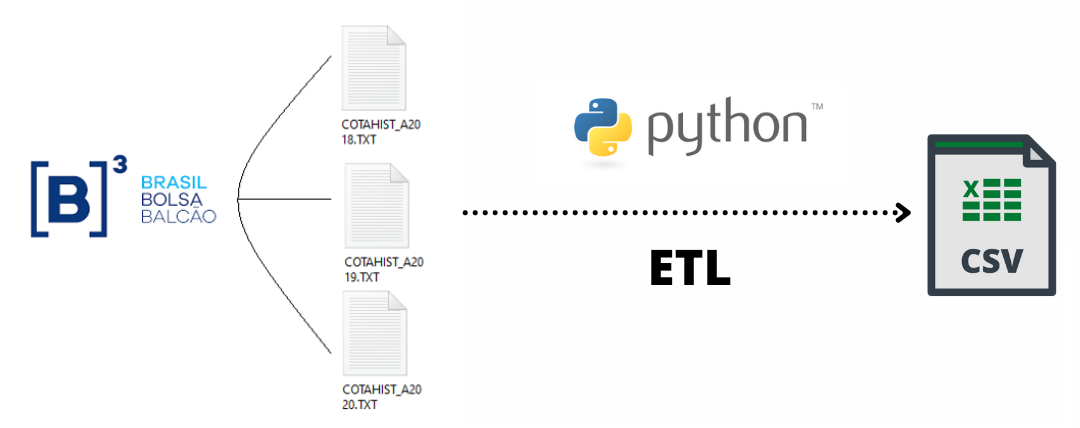
Iremos utilizar o ETL (extraction, Transformation and Load) a partir dos dados das cotações históricas da B3, transformá-los a partir de alguma regra e disponibiliza-los nesse repositório. Essa ETL servirá como base para alimentar futuros artigos sobre análise de dados e machine learning sobre dados da Bovespa.  

##Obtenção dos Dados
Iremos acessar o site da B3 para fazer o download das [séries históricas](http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/series-historicas/) anuais. Iremos recolher as séries históricas de 2018 até 2021.

Se trata de um arquivo posicional, aonde os dados estão disponibilizados em uma string no formato txt. Iremos transformá-los com a ajuda do layout disponibilizado pela B3 ([LAYOUT DO ARQUIVO – COTAÇÕES
HISTÓRICAS](http://www.b3.com.br/data/files/C8/F3/08/B4/297BE410F816C9E492D828A8/SeriesHistoricas_Layout.pdf))
e retirarmos as informações que queremos e disponibilizarmos de maneira simples. 

In [1]:
#Importando bibliotecas
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

A biblioteca `pandas` reconhece diversos tipos de arquivo. Como estamos lidando com um arquivo posicional, iremos usar o método `read_fwf`. Esse método, recebe o nome do arquivo e a posição das colunas, por isso, antes de criarmos, temos que deixar claro quais colunas iremos passar para o pandas.

Olhando para o layout, vemos que os dados que queremos se encontram após o *Header* (Na transformação do código, iremos passar um comando para pular a leitura da header), as *Cotações Históricas por Papel-Mercado*. Dela, iremos retirar as informações que queremos das ações.

Na primeira coluna se encontra o nome do campo e as duas últimas colunas aparecem a posição inicial e final delas na lista. Iremos usar isso para passar esses dados para o Pandas DataFrame. Irei criar duas listas, uma com o nome de cada campo e a outra com as posições que eu quero para cada campo.

In [ ]:
colspecs = [(2,10), 
            (10, 12), 
            (12,24),
            (27,39), 
            (56,69), 
            (69,82), 
            (82,95), 
            (108,121), 
            (152,170), 
            (170, 188)
            ]

names = ['Data_Pregao', 'Cod_BDI', 'Sigla_Acao', 'Nome_Acao', 'Prec_Abertura', 'Prec_Max', 
         'Prec_Min', 'Prec_Fechamento', 'Qtd_Titulos_Negociados', 'Vol_Negocios']

In [ ]:
df = pd.read_fwf('/content/drive/MyDrive/COTAHIST_A2020.TXT', colspecs=colspecs, names=names, skiprows = 1)

In [ ]:
df.head()

,Data_Pregao,Cod_BDI,Sigla_Acao,Nome_Acao,Prec_Abertura,Prec_Max,Prec_Min,Prec_Fechamento,Qtd_Titulos_Negociados,Vol_Negocios
0,20200102,2.0,AALR3,ALLIAR,1829.0,1900.0,1828.0,1900.0,585800.0,1.094620e+09
1,20200102,2.0,AAPL34,APPLE,12000.0,12134.0,12000.0,12134.0,12700.0,1.533380e+08
2,20200102,2.0,ABCB4,ABC BRASIL,2000.0,2030.0,1982.0,2030.0,870400.0,1.745788e+09
3,20200102,2.0,ABEV3,AMBEV S/A,1886.0,1925.0,1878.0,1920.0,16011300.0,3.062348e+10
4,20200102,2.0,ADHM3,ADVANCED-DH,255.0,255.0,235.0,248.0,193400.0,4.719270e+07


Agora temos o nosso DataFrame com as informações que queremos. Só falta fazer algumas transformações, por exemplo:
* A coluna `Data_Pregao` precisa ser passada para o formato `datetime`. 
* Também iremos restringir as ações negociadas ao lote padrão, i.e., `Cod_BDI ` com valor 2.0 (No layout tem explicando o que cada código representa).

* As colunas referentes ao preço se encontram multiplicadas por 100, precisamos fazer a divisão e passar o tipo para float.

##Limpeza

In [ ]:
#Deixando apenas ações com código padrão.
df= df[df['Cod_BDI']==2]
#Como agora todas as ações possuem código DBI com valor 2, essa coluna não é mais necessária
df.drop(columns=['Cod_BDI'], axis = 1, inplace = True );

In [ ]:
df.head()

,Data_Pregao,Sigla_Acao,Nome_Acao,Prec_Abertura,Prec_Max,Prec_Min,Prec_Fechamento,Qtd_Titulos_Negociados,Vol_Negocios
0,20200102,AALR3,ALLIAR,1829.0,1900.0,1828.0,1900.0,585800.0,1.094620e+09
1,20200102,AAPL34,APPLE,12000.0,12134.0,12000.0,12134.0,12700.0,1.533380e+08
2,20200102,ABCB4,ABC BRASIL,2000.0,2030.0,1982.0,2030.0,870400.0,1.745788e+09
3,20200102,ABEV3,AMBEV S/A,1886.0,1925.0,1878.0,1920.0,16011300.0,3.062348e+10
4,20200102,ADHM3,ADVANCED-DH,255.0,255.0,235.0,248.0,193400.0,4.719270e+07


In [ ]:
#Ajustar Datas
df['Data_Pregao'] = pd.to_datetime(df['Data_Pregao'], format='%Y%m%d')

In [ ]:
#Ajustar preço
df['Prec_Abertura'] = (df['Prec_Abertura']/100).astype(float);
df['Prec_Max'] = (df['Prec_Max']/100).astype(float);
df['Prec_Min'] = (df['Prec_Min']/100).astype(float);
df['Prec_Fechamento'] = (df['Prec_Fechamento']/100).astype(float);

In [ ]:
#DataSet Final
df.head()

,Data_Pregao,Sigla_Acao,Nome_Acao,Prec_Abertura,Prec_Max,Prec_Min,Prec_Fechamento,Qtd_Titulos_Negociados,Vol_Negocios
0,2020-01-02,AALR3,ALLIAR,18.29,19.00,18.28,19.00,585800.0,1.094620e+09
1,2020-01-02,AAPL34,APPLE,120.00,121.34,120.00,121.34,12700.0,1.533380e+08
2,2020-01-02,ABCB4,ABC BRASIL,20.00,20.30,19.82,20.30,870400.0,1.745788e+09
3,2020-01-02,ABEV3,AMBEV S/A,18.86,19.25,18.78,19.20,16011300.0,3.062348e+10
4,2020-01-02,ADHM3,ADVANCED-DH,2.55,2.55,2.35,2.48,193400.0,4.719270e+07


##Criando uma Função ETL
O que queremos agora é criar uma função que passemos esses parâmetros e irá realizar toda limpeza e transformação que fizemos acima de forma otimizada e fazer o download do DataSet final.

Iremos criar funções para otimizar esse processo de retirada, limpeza e transformação dos dados.

A primeira função `read_files()` vai receber partes das strings que compõe o nome do arquivo, no qual serão concatenadas em uma [f-string](https://realpython.com/python-f-strings/) e criado nosso dataset a partir do método `pd.read_fwf`, que irá receber essa *f-string* como parâmetro (Irá ficar mais claro posteriormente quando aplicar a função).

In [2]:
def read_files(path, name_file, year_date, type_file):
  _file = f'{path}{name_file}{year_date}.{type_file}'

  colspecs = [(2,10), 
            (10, 12), 
            (12,24),
            (27,39), 
            (56,69), 
            (69,82), 
            (82,95), 
            (108,121), 
            (152,170), 
            (170, 188)
            ]

  names = ['Data_Pregao', 'Cod_BDI', 'Sigla_Acao', 'Nome_Acao', 'Prec_Abertura', 'Prec_Max', 
         'Prec_Min', 'Prec_Fechamento', 'Qtd_Titulos_Negociados', 'Vol_Negocios']

  df = pd.read_fwf(_file, colspecs=colspecs, names=names, skiprows = 1) 

  return df

As demais funções `filter_stocks`, `parse_date`, `parse_values` fazem a limpeza e a transformações das colunas que vimos acima. 

In [3]:
def filter_stocks(df):
  df = df[df['Cod_BDI']==2]
  df.drop(columns=['Cod_BDI'], axis = 1, inplace = True );
  return df

In [4]:
def parse_date(df):
  df['Data_Pregao'] = pd.to_datetime(df['Data_Pregao'], format='%Y%m%d')
  return df

In [5]:
def parse_values(df):
  df['Prec_Abertura'] = (df['Prec_Abertura']/100).astype(float)
  df['Prec_Max'] = (df['Prec_Max']/100).astype(float)
  df['Prec_Min'] = (df['Prec_Min']/100).astype(float)
  df['Prec_Fechamento'] = (df['Prec_Fechamento']/100).astype(float)
  return df

As cotações históricas da B3 possuem informações desde a década de 80. O código abaixo irá pegar uma lista com os anos no qual quer analisar, cria um arquivo csv contendo as informações que pedimos acima para todos esses anos e finalmente disponibilizar para download. No qual agora pode ser feita a análise do dataset de forma prática.


In [6]:
#Juntando os arquivos
def concat_files(path, name_file, year_date, type_file, final_file):
  
  for i, y in enumerate(year_date):
    df = read_files(path, name_file, y, type_file)
    df = filter_stocks(df)
    df = parse_date(df)
    df = parse_values(df)
    '''i=0 se refere ao primeiro dataset, logo ele será chamado de final na primeira iteração
       nas demais, ele irá concatenar os dataframes em um só. '''
    if i == 0:
      df_final = df
    else:
      df_final = pd.concat([df_final, df])

    df_final.to_csv(final_file, index=False)
    
    

Aqui abaixo se encontram os anos das cotações que irei disponibilizar no arquivo csv. 

In [8]:
#Executando o ETL
year_date = [2018, 2019, 2020,2021]
path = f'/content/drive/MyDrive/'
name_file = 'COTAHIST_A'
type_file ='TXT'
final_file = 'All_Bovespa.csv'
concat_files(path, name_file, year_date, type_file, final_file);


##Download

In [9]:
#Download do arquivo csv criado
from google.colab import files
files.download(final_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>